# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import h5py
from pathlib import Path
import time
from tqdm import tqdm
import csv
import os
from tqdm import tqdm, trange
import pydot

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras import activations
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['font.family'] = "sans-serif"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2022-07-04 13:20:41.034782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(f'tf.test.is_built_with_cuda(): {tf.test.is_built_with_cuda()}');

if tf.__version__[0] == '1':
    print(f'tf.config.experimental_list_devices(): {tf.config.experimental_list_devices()}');
else:
    print(f'tf.config.list_physical_devices("GPU"): {tf.config.list_physical_devices("GPU")}');
    
print(f'tf.test.gpu_device_name(): {tf.test.gpu_device_name()}');

tf.test.is_built_with_cuda(): True
tf.config.list_physical_devices("GPU"): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.test.gpu_device_name(): /device:GPU:0


2022-07-04 13:21:06.563558: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-04 13:21:06.565714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-04 13:21:06.904493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:e5:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2022-07-04 13:21:06.904573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-04 13:21:07.103472: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-04 13:21:07.103623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10


# Settings

In [3]:
# randst = np.random.randint(0,100)
randst = 94
np.random.seed(randst)
print(randst)

verbosity = 0

94


# Define functions

In [4]:
def compute_scores(y_test, y_hat):
    mae = mean_absolute_error(y_test, y_hat)
    mre = mean_absolute_percentage_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    metrics = [mae, mre, r2]
    mae_per = mean_absolute_error(y_test, y_hat, multioutput='raw_values')
    mre_per = mean_absolute_percentage_error(y_test, y_hat, multioutput="raw_values")
    r2_per = r2_score(y_test, y_hat, multioutput='raw_values')
    metrics_per = [mae_per, mre_per, r2_per]
    return metrics, metrics_per

def print_my_results(results_mae, results_mae_per, results_r2, results_r2_per, results_mre=None, results_mre_per=None):
    
    print('MAE:')
    print('\t%.3f (%.3f) overall' % (np.mean(results_mae), np.std(results_mae)))
    for mae,std,idx in zip(np.mean(results_mae_per, axis=0), np.std(results_mae_per, axis=0), idx_params):
        print('\t%.3f (%.3f) %s' % (mae, std, labels[idx]) )
    if results_mre is not None:
        print('MRE:')
        print('\t%.3f (%.3f) overall' % (np.mean(results_mre), np.std(results_mre)))
        for mre,std,idx in zip(np.mean(results_mre_per, axis=0), np.std(results_mre_per, axis=0), idx_params):
            print('\t%.3f (%.3f) %s' % (mre, std, labels[idx]) )
    print('R2:')
    print('\t%.3f (%.3f) overall' %(np.mean(results_r2), np.std(results_r2)))
    for r2,std,idx in zip(np.mean(results_r2_per, axis=0), np.std(results_r2_per, axis=0), idx_params):
        print('\t%.3f (%.3f) %s' % (r2, std, labels[idx]) )
        

# Import and partition data

In [5]:
scalar_on = 1
cdt_on = 0
drug_train_on = 1
downsample_on = 1
N_train = 4000

## Import data and test case indices

In [6]:
name = "n4130"
here = Path.cwd()
data_path = Path(here.joinpath(f"data/data_control_{name}.h5"))

with h5py.File(data_path, 'r') as f:
    Datasetnames=f.keys()
    print(*list(Datasetnames), sep = "\n")
    trace = f['trace'][:,:200,:] # select time 0-200
    t = f['time'][...]
    adj_factors = f['adjustment_factors'][...]
    cost_terms = f['cost_terms'][...]
    
if trace.shape[0] != adj_factors.shape[0]:
    print('Number of samples do not match for trace and adj_factors!')

N_def = trace.shape[0]
print("Number of traces (control):", N_def)
labels = ["g_Kr","g_CaL","lambda_B","g_NaCa","g_K1","J_SERCA_bar","lambda_diff","lambda_RyR","g_bCa","g_Na","g_NaL"]

# Separate test cases (n=50) from all cases
idx_all = list(np.arange(0,trace.shape[0]))
idx_test = list(np.loadtxt(here.joinpath("data/idx_key_p11_s100_n5000_ns50.txt"), dtype=int))
idx_train = list(set(idx_all) - set(idx_test))

if drug_train_on:
    data_path = Path(here.joinpath(f"data/data_drug-combo_blockX_{name}.h5"))
    with h5py.File(data_path, 'r') as f:
        trace = np.vstack((trace, f['trace'][:,:200,:])) # select time 0-200
        adj_factors = np.vstack((adj_factors, f['adjustment_factors'][...]))
        cost_terms = np.vstack((cost_terms, f['cost_terms'][...]))
    idx_all = list(np.arange(0,trace.shape[0]))
    a = np.loadtxt(here.joinpath("data/idx_key_p11_s100_n5000_ns50.txt"), dtype=int)
    idx_test = list(a)
    idx_exclude = list(np.concatenate((a, a+N_def))) # remove test and modified test from idx_train
    idx_train = list(set(idx_all) - set(idx_exclude))
    N_def = trace.shape[0]
    print("Number of traces (all):", N_def)

adjustment_factors
cost_terms
time
trace
Number of traces (control): 4130
Number of traces (all): 8260


## Partition data
Test cases are pre-selected for out-of-sample testing

In [8]:
if not cdt_on:
    idx_params = [0,1,4,9,10]
    trace_train = trace[idx_train,:,:]
    trace_test = trace[idx_test,:,:]
    af_train = adj_factors[idx_train,:][:,idx_params]
    af_test = adj_factors[idx_test,:][:,idx_params]

    if downsample_on:
        idx_down = np.random.choice(af_train.shape[0], N_train, replace=False)
        trace_train = trace_train[idx_down,:,:]
        af_train = af_train[idx_down,:]
        
elif cdt_on:
    import transportBasedTransforms.cdt as CDT
    trace_cdt = np.zeros_like(trace)
    N=200
    I0= (1.0/N)*np.ones(N)
    cdt=CDT.CDT(template=I0)

    for i in range(trace.shape[0]):
        for j in range(trace.shape[2]):
            trace_cdt[i,:,j] = cdt.transform(trace[i,:,j])

    idx_params = [0,1,4,9,10]
    trace_train = trace_cdt[idx_train,:,:]
    trace_test = trace_cdt[idx_test,:,:]
    af_train = adj_factors[idx_train,:][:,idx_params]
    af_test = adj_factors[idx_test,:][:,idx_params]
    
    if downsample_on:
        idx_down = np.random.choice(af_train.shape[0], N_train, replace=False)
        trace_train = trace_train[idx_down,:,:]
        af_train = af_train[idx_down,:]
        
print("Number of training cases:", af_train.shape[0])

Number of training cases: 4000


## Drug effect target data
Import as 4 datasets: control, drug-Kr, drug-CaL, drug-combo

No partitioning needed since training with control data

In [9]:
trace_drug = []
af_drug = []

block = "block20"
names_data = ["control", f"drug-Kr_{block}", f"drug-CaL_{block}", f"drug-combo_{block}"]

here = Path.cwd()

for name in names_data:
    data_path = Path(here.joinpath(f"data/data_{name}_n50.h5"))
    with h5py.File(data_path, "r") as f:
        trace_drug.append(f["trace"][:,:200,:])
        af_drug.append(f["adjustment_factors"][:,:])

trace_drug = np.array(trace_drug)
af_drug = np.array(af_drug)

In [10]:
if not cdt_on:
    trace_drug_test = np.copy(trace_drug)
    af_drug_test = af_drug[:,:,idx_params]

elif cdt_on:
    trace_drug_test = np.zeros_like(trace_drug)

    for k in range(trace_drug_test.shape[0]):
        for i in range(trace_drug_test.shape[1]):
            for j in range(trace_drug_test.shape[3]):
                trace_drug_test[k,i,:,j] = cdt.transform(trace_drug[k,i,:,j])

    af_drug_test = af_drug[:,:,idx_params]

# Parameter tuning for kNN, RF, SVM

## k-Nearest Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [34]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train
if scalar_on:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

print('X shape:',X.shape)
print('Feature shape:',y.shape)

X shape: (4080, 400)
Feature shape: (4080, 5)


In [35]:
knn_grid = {"n_neighbors": np.arange(1, 20),
            "weights": ['uniform', 'distance'],
            "p": [1,2],
              }

knn_base = KNeighborsRegressor()
knn_gscv = GridSearchCV(estimator = knn_base, param_grid = knn_grid,
                        cv=5, verbose=2,
                        n_jobs=-1)
knn_gscv.fit(X, y)

print(knn_gscv.best_params_)

Fitting 5 folds for each of 76 candidates, totalling 380 fits
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.1s
[CV] END ................n_neighbors=2, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=2, p=1, we

[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=1, p=2, weights=distance; total time=   0.1s
[CV] END ................n_neighbors=2, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=2, p=1, weights=uniform; total time=   1.2s
[CV] END ...............n_ne

## Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [ ]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train
scaler = StandardScaler()
X = scaler.fit_transform(X)

print('X shape:',X.shape)
print('Feature shape:',y.shape)

In [ ]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 6)]
rf_max_depth.append(None)

# Number of features to consider at every split
# rf_max_features = ['auto', 'sqrt', 'log2']
rf_max_features = ['log2']

# Criterion to split on
rf_criterion = ['absolute_error']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_base = RandomForestRegressor()

# Create the random search Random Forest
rf_gscv = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid,
                               n_iter=2, cv = 5, verbose = 2,
                               n_jobs = -1)

# Fit the random search model
rf_gscv.fit(X, y)

# View the best parameters from the random search
print(rf_gscv.best_params_)
with open("rfr_cv_output.txt","w") as f:
    f.write(rf_gscv.best_params_)


## Support Vector
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [12]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train
if scalar_on:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

print('X shape:',X.shape)
print('Feature shape:',y.shape)

X shape: (4080, 400)
Feature shape: (4080, 5)


In [13]:
gamma_range = list(np.logspace(-6, 3, 9))
gamma_range.append("scale")
gamma_range.append("auto")


svr_grid = {
#     "estimator__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "estimator__kernel": ["rbf"],
    "estimator__gamma": ["scale", "auto"],
    "estimator__C": [0.1, 1, 10, 100],
    "estimator__epsilon": [0.001, 0.01, 0.1, 1, 10],
#     "estimator__shrinking": [True, False]
}

start = time.time()
svr_base = MultiOutputRegressor(SVR())
svr_gscv = GridSearchCV(estimator = svr_base, param_grid = svr_grid,
                        cv=3, verbose=2,
                        n_jobs=-1)
svr_gscv.fit(X, y)
stop = time.time()
print(svr_gscv.best_params_)
print(stop-start)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END ..............n_neighbors=14, p=2, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=15, p=1, weights=uniform; total time=   1.3s
[CV] END ...............n_neighbors=15, p=1, weights=uniform; total time=   1.3s
[CV] END ..............n_neighbors=15, p=1, weights=distance; total time=   1.3s
[CV] END ..............n_neighbors=15, p=1, weights=distance; total time=   1.3s
[CV] END ..............n_neighbors=15, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_neighbors=15, p=2, weights=uniform; total time=   0.1s
[CV] END ..............n_neighbors=15, p=2, weights=distance; total time=   0.1s
[CV] END ..............n_neighbors=15, p=2, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=16, p=1, weights=uniform; total time=   1.3s
[CV] END ...............n_neighbors=16, p=1, weights=uniform; total time=   1.3s
[CV] END ..............n_neighbors=16, p=1, wei

{'estimator__C': 100, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
650.3932287693024
[CV] END ..............n_neighbors=19, p=1, weights=distance; total time=   1.3s
[CV] END ..............n_neighbors=19, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_neighbors=19, p=2, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=19, p=2, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=19, p=2, weights=uniform; total time=   0.1s
[CV] END ..............n_neighbors=19, p=2, weights=distance; total time=   0.1s
[CV] END ..............n_neighbors=19, p=2, weights=distance; total time=   0.1s
[CV] END ..............n_neighbors=19, p=2, weights=distance; total time=   0.1s
[CV] END estimator__C=0.1, estimator__epsilon=0.001, estimator__gamma=scale, estimator__kernel=rbf; total time=  20.6s
[CV] END estimator__C=0.1, estimator__epsilon=0.001, estimator__gamma=scale, estimator__kernel=rbf; total tim

## Define best parameters for kNN, SVR

In [38]:
# For normal data
# knn_best = {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
# svr_best = {'C': 1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'} # actual from GridSearchCV
# svr_best = {'C': 0.01, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}

# For CDT data
knn_best = {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
svr_best = {'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

# Evaluate models using k-fold cross-validation

https://scikit-learn.org/stable/modules/learning_curve.html


## k-Nearest Neighbor

### Prep data

In [39]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train

print('X shape:',X.shape)
print('Feature shape:',y.shape)

X shape: (8160, 400)
Feature shape: (8160, 5)


### Define model

In [40]:
def get_model_knn(**kwargs):
    model = KNeighborsRegressor(**kwargs,
                               n_jobs=-1)
    return model

def evaluate_model_knn(X, y):
    results_mae = []
    results_mae_per = []
    results_mre = []
    results_mre_per = []
    results_r2 = []
    results_r2_per = []
    
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=randst)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        if scalar_on:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # define model
        model = get_model_knn(**knn_best)
        # fit model
        model.fit(X_train, y_train)
        # evaluate model on test set
        y_hat = model.predict(X_test)
        
        scores, scores_per = compute_scores(y_test, y_hat)
        
        # store result
        print('>%.3f' % scores[0])
        results_mae.append(scores[0])
        results_mae_per.append(scores_per[0])
        results_mre.append(scores[1])
        results_mre_per.append(scores_per[1])
        results_r2.append(scores[2])
        results_r2_per.append(scores_per[2])
    return results_mae, results_mae_per, results_mre, results_mre_per, results_r2, results_r2_per


### Run model with k-fold cross-validation

In [41]:
start = time.time()
results_mae, results_mae_per, results_mre, results_mre_per, results_r2, results_r2_per = evaluate_model_knn(X, y)
stop = time.time()
print('Time of execution: %f' % (stop-start))

print_my_results(results_mae, results_mae_per, results_r2, results_r2_per)

>0.128
>0.128
>0.125
>0.128
>0.126
>0.126
>0.127
>0.128
>0.127
>0.127
>0.128
>0.127
>0.128
>0.126
>0.127
Time of execution: 7.226896
MAE:
	0.127 (0.001) overall
	0.099 (0.002) g_Kr
	0.118 (0.003) g_CaL
	0.103 (0.001) g_K1
	0.154 (0.002) g_Na
	0.162 (0.002) g_NaL
R2:
	0.360 (0.007) overall
	0.763 (0.012) g_Kr
	0.787 (0.008) g_CaL
	0.258 (0.015) g_K1
	0.041 (0.016) g_Na
	-0.051 (0.020) g_NaL


## Random Forest

### Prep data

In [ ]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train

print('X shape:',X.shape)
print('Feature shape:',y.shape)

### Define model using best_params

In [41]:
def get_model_rfr(**kwargs):
    model = RandomForestRegressor(**kwargs)
    return model

def evaluate_model_rfr(X, y):
    results_mae = list()
    results_mae_per = list()
    results_r2 = list()
    results_r2_per = list()
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=randst)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        if scalar_on:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # define model
        model = get_model_rfr(**rf_gscv.best_params_)
        # fit model
        model.fit(X_train, y_train)
        # evaluate model on test set
        y_hat = model.predict(X_test)
        r2_per = r2_score(y_test,y_hat,multioutput='raw_values')
        r2 = r2_score(y_test,y_hat)
        mae = mean_absolute_error(y_test, y_hat)
        mae_per = mean_absolute_error(y_test, y_hat, multioutput='raw_values')
        # store result
        print('>%.3f' % mae)
        results_mae.append(mae)
        results_mae_per.append(mae_per)
        results_r2.append(r2)
        results_r2_per.append(r2_per)
    return results_mae, results_mae_per, results_r2, results_r2_per

### Run model with k-fold cross-validation

In [42]:
start = time.time()
results_mae, results_mae_per, results_r2, results_r2_per = evaluate_model_rfr(X, y)
stop = time.time()
print('Time of execution: %f' % (np.divide(stop-start, 60)))

print_my_results(results_mae, results_mae_per, results_r2, results_r2_per)

SyntaxError: invalid syntax (1109395613.py, line 6)

## Support Vector Regression

### Prep data

In [27]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train

print('X shape:',X.shape)
print('Feature shape:',y.shape)

X shape: (4080, 400)
Feature shape: (4080, 5)


### Define model

In [30]:
def get_model_svr(**kwargs):
    svr = SVR(**kwargs)

    model = MultiOutputRegressor(svr)
    return model

def evaluate_model_svr(X, y):
    results_mae = list()
    results_mae_per = list()
    results_r2 = list()
    results_r2_per = list()
    svr_train_error = list()
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=randst)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        if scalar_on:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # define model
        model = get_model_svr(**svr_best)
        # fit model
        model.fit(X_train, y_train)
        # evaluate model on test set
        y_hat = model.predict(X_test)
        scores, scores_per = compute_scores(y_test, y_hat)
        svr_train_error.append(mean_absolute_error(y_train, model.predict(X_train)))
        # store result
        print('>%.3f' % scores[0])
        results_mae.append(scores[0])
        results_mae_per.append(scores_per[0])
        results_r2.append(scores[2])
        results_r2_per.append(scores_per[2])
    return results_mae, results_mae_per, results_r2, results_r2_per, svr_train_error

### Run model with k-fold cross-validation

In [31]:
start = time.time()
results_mae, results_mae_per, results_r2, results_r2_per, svr_train_error = evaluate_model_svr(X, y)
stop = time.time()
print('Time of execution: %f' % (np.divide(stop-start, 60)))

print_my_results(results_mae, results_mae_per, results_r2, results_r2_per)

>0.092
>0.093
>0.093
>0.090
>0.092
>0.092
>0.090
>0.093
>0.092
>0.092
>0.092
>0.090
>0.092
>0.093
>0.093
Time of execution: 0.683908
MAE:
	0.092 (0.001) overall
	0.073 (0.002) g_Kr
	0.076 (0.002) g_CaL
	0.049 (0.002) g_K1
	0.110 (0.004) g_Na
	0.152 (0.003) g_NaL
R2:
	0.641 (0.008) overall
	0.871 (0.008) g_Kr
	0.925 (0.004) g_CaL
	0.818 (0.025) g_K1
	0.518 (0.014) g_Na
	0.074 (0.019) g_NaL


### Evaluate ratio of training and validation error (last epoch)

In [13]:
svr_validate = np.copy(results_mae)
results_svr = np.zeros((15,3))
for i in range(15):
    results_svr[i,0] = svr_train_error[i]
    results_svr[i,1] = svr_validate[i]
    results_svr[i,2] = svr_validate[i]/svr_train_error[i]
    
np.savetxt("train_test_loss_svr.csv", results_svr, delimiter=',')

## Multi-Layer Perceptron

### Prep data

In [13]:
X = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
y = af_train

print('X shape:',X.shape)
print('Feature shape:',y.shape)

X shape: (4000, 400)
Feature shape: (4000, 5)


### Define model

In [18]:
dropout = 0.0
weight_reg = 0.01
lr = 0.001
loss_metric = "mse"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    
def get_model_mlp1(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(500, input_dim=n_inputs,
                    kernel_initializer='he_uniform',
                    activation=activations.swish,
                    kernel_regularizer=l2(weight_reg), bias_regularizer=l2(weight_reg)
                   )
             )
    model.add(Dropout(dropout))
    model.add(Dense(n_outputs), activation=activations.tanh)
    model.compile(loss='mae', optimizer=Adam(learning_rate=lr), metrics="mae")
    return model

def get_model_mlp3(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(100, input_dim=n_inputs,
                    kernel_initializer='he_uniform',
                    activation=activations.swish,
                    kernel_regularizer=l2(weight_reg), bias_regularizer=l2(weight_reg)
                   )
             )
    model.add(Dropout(dropout))
    model.add(Dense(100, activation=activations.swish,
                    kernel_regularizer=l2(weight_reg), bias_regularizer=l2(weight_reg)
                   )
             )
    model.add(Dropout(dropout))
    model.add(Dense(100, activation=activations.swish,
                    kernel_regularizer=l2(weight_reg), bias_regularizer=l2(weight_reg)
                   )
             )
    model.add(Dropout(dropout))
    model.add(Dense(n_outputs, activation=activations.tanh))
    model.compile(loss='mae', optimizer=Adam(learning_rate=lr), metrics="mae")
    return model

def evaluate_model_mlp(X, y):
    results_mae = list()
    results_mae_per = list()
    results_r2 = list()
    results_r2_per = list()
    mlp_trained = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=randst)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        if scalar_on:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        model = get_model_mlp1_test(n_inputs, n_outputs) # <<<<< SPECIFY WHICH MLP MODEL
        
        mlp_trained.append(model.fit(X_train, y_train, validation_split = 0.1, shuffle = False, epochs=200,
                                     batch_size=32,
                                     verbose=verbosity,
#                                      callbacks=[callback]
                                     )
                          )
        
        y_hat = model.predict(X_test)
        scores, scores_per = compute_scores(y_test, y_hat)
        # store result
        print('>%.3f' % scores[0])
        results_mae.append(scores[0])
        results_mae_per.append(scores_per[0])
        results_r2.append(scores[2])
        results_r2_per.append(scores_per[2])
    return results_mae, results_mae_per, results_r2, results_r2_per, mlp_trained

### Run model with k-fold cross-validation

In [44]:
start = time.time()
results_mae, results_mae_per, results_r2, results_r2_per, mlp_trained = evaluate_model_mlp(X, y)
stop = time.time()
print('Time of execution: %f' % (np.divide(stop-start, 60)))

print_my_results(results_mae, results_mae_per, results_r2, results_r2_per)

2022-06-03 14:50:02.964511: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 14:50:02.967259: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-03 14:50:03.429148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:36:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2022-06-03 14:50:03.432883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:39:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2022-06-03 14:50:03.432971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
202

>0.154
>0.162
>0.157
>0.153


KeyboardInterrupt: 

In [142]:
name = "mlp_1layer100n_dropout0_regular0_batch32_cdt"

### Evaluate ratio of training and validation error (last epoch)

In [143]:
mlp_validate = np.copy(results_mae)
results_mlp = np.zeros((15,3))
for i in range(15):
    results_mlp[i,0] = mlp_trained[i].history["mae"][-1]
    results_mlp[i,1] = mlp_validate[i]
    results_mlp[i,2] = mlp_validate[i]/mlp_trained[i].history["mae"][-1]
    
np.savetxt(f"overfit_test/history_{name}.csv", results_mlp, delimiter=',')
    

### Plot learning curves

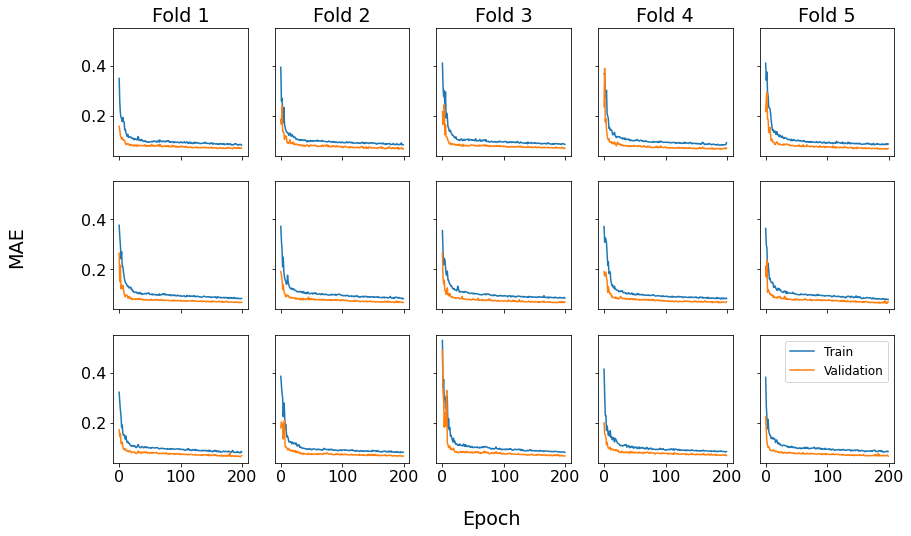

In [144]:
fig, axs = plt.subplots(3,5,figsize=(14,8), sharey = True, sharex = True)
axs = axs.T.flatten()
for i, ax in enumerate(axs):
    ax.plot(mlp_trained[i].history["loss"])
    ax.plot(mlp_trained[i].history["val_loss"])
    ax.set_xticks([0,100,200])
    if i in [0,3,6,9,12,15]:
        ax.set_title(f"Fold {i//3+1:d}")
        
axs[-1].legend(["Train","Validation"], prop={'size': 12})
fig.supxlabel('Epoch')
fig.supylabel('MAE')

plt.savefig(f"overfit_test/learning_curve_{name}.png", dpi=300, bbox_inches="tight")

## Convolutional Neural Network

### Prep data

In [37]:
X = np.copy(trace_train)
y = af_train

print('X shape:',X.shape)
print('Feature shape:',y.shape)

X shape: (4000, 200, 2)
Feature shape: (4000, 5)


### Define model

In [11]:
dropout = 0.0
weight_reg = 0.001
lr = 0.001
conv2d_on = True

def get_model_cnn3(n_inputs, n_outputs):
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=6, input_shape=(200,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activations.swish))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activations.swish))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activations.swish))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    model.add(Flatten())
    model.add(Dense(64, activation=activations.swish))
    model.add(Dropout(dropout))
    model.add(Dense(n_outputs, activation=activations.tanh))
    model.compile(loss='mae', optimizer='adam', metrics="mae")
    return model

def get_model_cnn1(n_inputs, n_outputs):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, input_shape=n_inputs))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation=activations.swish))
    model.add(Dropout(dropout))
    model.add(Dense(n_outputs, activation=activations.tanh))
    model.compile(loss='mae', optimizer='adam', metrics="mae")
    return model


def get_model_cnn1_2d(n_inputs, n_outputs):
    model = Sequential()
    model.add(Conv1D(filters=32,
                     kernel_size=2,
                     input_shape=(200, 2, 1),
                     kernel_regularizer=l2(weight_reg),
                     # bias_regularizer=l2(weight_reg),
                    )
             )
    model.add(MaxPooling2D(pool_size=(2,2), padding="same"))
    model.add(Flatten())
    model.add(Dense(64, activation=activations.swish,
                    kernel_regularizer=l2(weight_reg),
                    # bias_regularizer=l2(weight_reg)
                   )
             )
    model.add(Dropout(dropout))
    model.add(Dense(n_outputs, activation=activations.tanh))
    model.compile(loss='mae', optimizer=Adam(learning_rate=lr), metrics="mae")
    return model


def evaluate_model_cnn(X, y):
    results_mae = list()
    results_mae_per = list()
    results_r2 = list()
    results_r2_per = list()
    cnn_trained = list()
    n_inputs, n_outputs = X.shape[1:], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=randst)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        if scalar_on:
            scalers = {}
            for i in range(X_train.shape[2]):
                scalers[i] = StandardScaler()
                X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])
            for i in range(X_test.shape[2]):
                X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])
        if conv2d_on:
            X_train = np.expand_dims(X_train, -1)
            X_test = np.expand_dims(X_test, -1)
        model = get_model_cnn1_2d(n_inputs, n_outputs)
        
        cnn_trained.append(model.fit(X_train, y_train, validation_split = 0.1, shuffle = False, epochs=200,
                                      verbose=verbosity
                                     )
                          )
        
        y_hat = model.predict(X_test)
        scores, scores_per = compute_scores(y_test, y_hat)
        # store result
        print('>%.3f' % scores[0])
        results_mae.append(scores[0])
        results_mae_per.append(scores_per[0])
        results_r2.append(scores[2])
        results_r2_per.append(scores_per[2])
    return results_mae, results_mae_per, results_r2, results_r2_per, cnn_trained

### Run model with k-fold cross-validation

In [ ]:
start = time.time()
results_mae, results_mae_per, results_r2, results_r2_per, cnn_trained = evaluate_model_cnn(X, y)
stop = time.time()
print('Time of execution: %f' % (np.divide(stop-start, 60)))

print_my_results(results_mae, results_mae_per, results_r2, results_r2_per)

>0.084
>0.082
>0.088
>0.089
>0.086
>0.092
>0.092
>0.085
>0.087
>0.090
>0.086
>0.086
>0.085
>0.081


In [45]:
name = "cnn1-2d"

### Evaluate ratio of training and validation error (last epoch)

In [46]:
cnn_validate = np.copy(results_mae)
results_cnn = np.zeros((15,3))
for i in range(15):
    results_cnn[i,0] = cnn_trained[i].history["loss"][-1]
    results_cnn[i,1] = cnn_validate[i]
    results_cnn[i,2] = cnn_validate[i]/cnn_trained[i].history["loss"][-1]
    
# np.savetxt(f"overfit_test/history_{name}.csv", results_cnn, delimiter=',')
    

### Plot learning curves

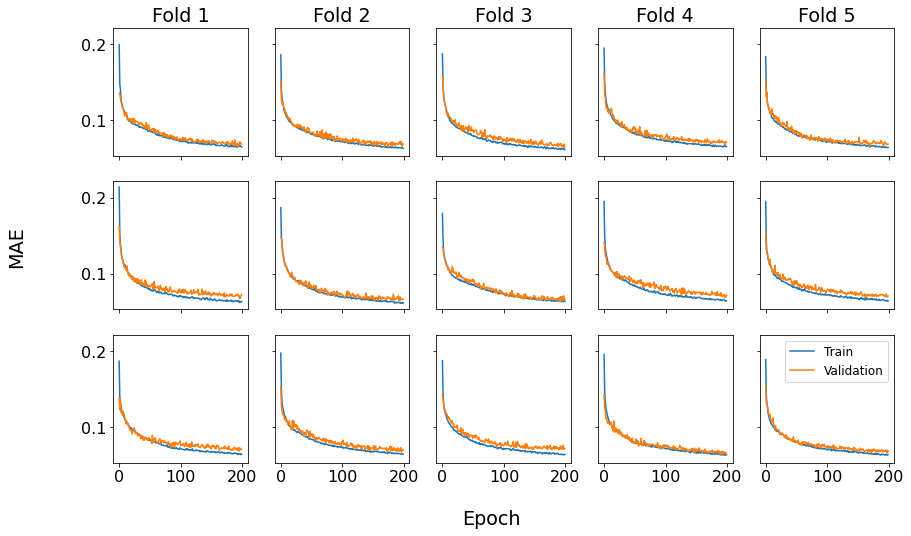

In [47]:
fig, axs = plt.subplots(3,5,figsize=(14,8), sharey = True, sharex = True)
axs = axs.T.flatten()
for i, ax in enumerate(axs):
    ax.plot(cnn_trained[i].history["loss"])
    ax.plot(cnn_trained[i].history["val_loss"])
    ax.set_xticks([0,100,200])
    if i in [0,3,6,9,12,15]:
        ax.set_title(f"Fold {i//3+1:d}")
        
axs[-1].legend(["Train","Validation"], prop={'size': 12})
fig.supxlabel('Epoch')
fig.supylabel('MAE')

plt.savefig(f"overfit_test/learning_curve_{name}.png", dpi=300, bbox_inches="tight")

## Fully Convolutional Neural Networks (FCN)

### Prep data

In [ ]:
X = np.copy(trace_train)
y = af_train

print('X shape:',X.shape)
print('Feature shape:',y.shape)

### Define model

In [16]:
def get_model_fcn(n_inputs, n_outputs):
    x = keras.layers.Input(n_inputs)
    drop_out = Dropout(0.1)(x)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=8, input_shape=n_inputs, padding='same')(x) # default filter 128
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activations.swish)(conv1)

    drop_out = Dropout(0.1)(conv1)
    conv2 = keras.layers.Conv1D(filters=128, kernel_size=5, padding='same')(conv1) # default filter 256
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation(activations.swish)(conv2)

    drop_out = Dropout(0.1)(conv2)
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same')(conv2) # default filter 128
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation(activations.swish)(conv3)

    full = keras.layers.GlobalAveragePooling1D()(conv3)
#     full = keras.layers.GlobalMaxPooling1D()(conv3)
    out = keras.layers.Dense(n_outputs)(full)
    model = keras.models.Model(inputs=x, outputs=out)

    optimizer = keras.optimizers.Adam()
    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model

def get_model_fcn_2(n_inputs, n_outputs):
    model = Sequential()
#     model.add(Dropout(0.1))
    model.add(Conv1D(filters=128, kernel_size=8, input_shape=n_inputs, padding='same'))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
#     model.add(Dropout(0.1))
    model.add(Conv1D(filters=256, kernel_size=5, input_shape=n_inputs, padding='same'))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
#     model.add(Dropout(0.1))
    model.add(Conv1D(filters=128, kernel_size=3, input_shape=n_inputs, padding='same'))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
    model.add(GlobalAveragePooling1D())
#     model.add(MaxPooling1D())
#     model.add(AveragePooling1D())
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model
    
def evaluate_model_fcn(X, y):
    results_mae = list()
    results_mae_per = list()
    results_r2 = list()
    results_r2_per = list()
    fcn_trained = list()
    n_inputs, n_outputs = X.shape[1:], y.shape[1]
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=randst)
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix,:,:], X[test_ix,:,:]
        y_train, y_test = y[train_ix], y[test_ix]
        nbatch, n_time, n_channel  = X_train.shape[0], X_train.shape[1], X_train.shape[2]
        if scalar_on:
            scalers = {}
            for i in range(X_train.shape[2]):
                scalers[i] = StandardScaler()
                X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])
            for i in range(X_test.shape[2]):
                X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])
        model = get_model_fcn(n_inputs, n_outputs)
        
        fcn_trained.append(model.fit(X_train, y_train,
                                     validation_split = 0.1,
                                     shuffle = True,
                                     epochs=300,
                                     verbose=verbosity
                                     )
                          )
        
        y_hat = model.predict(X_test)
        scores, scores_per = compute_scores(y_test, y_hat)
        # store result
        print('>%.3f' % scores[0])
        results_mae.append(scores[0])
        results_mae_per.append(scores_per[0])
        results_r2.append(scores[2])
        results_r2_per.append(scores_per[2])
    return results_mae, results_mae_per, results_r2, results_r2_per, fcn_trained


### Run model with k-fold cross-validation

In [ ]:
start = time.time()
results_mae, results_mae_per, results_r2, results_r2_per, fcn_trained = evaluate_model_fcn(X, y)
keras.backend.clear_session()
stop = time.time()
print('Time of execution: %f' % (np.divide(stop-start, 60)))

print_my_results(results_mae, results_mae_per, results_r2, results_r2_per)

### Evaluate ratio of training and validation error (last epoch)

In [ ]:
fcn_validate = np.copy(results_mae)
results_fcn = np.zeros((15,3))
for i in range(15):
    results_fcn[i,0] = fcn_trained[i].history["mae"][-1]
    results_fcn[i,1] = fcn_validate[i]
    results_fcn[i,2] = fcn_validate[i]/fcn_trained[i].history["mae"][-1]
    
np.savetxt("fcn_train_test_loss.csv", results_fcn)

### Plot learning curves

In [ ]:
fig, axs = plt.subplots(3,5,figsize=(14,8), sharey = True, sharex = True)
axs = axs.T.flatten()
for i, ax in enumerate(axs):
    ax.plot(fcn_trained[i].history["loss"])
    ax.plot(fcn_trained[i].history["val_loss"])
    ax.set_xticks([0,100,200])
    if i in [0,3,6,9,12,15]:
        ax.set_title(f"Fold {i//3+1:d}")
        
axs[-1].legend(["Train","Validation"], prop={'size': 12})
fig.supxlabel('Epoch')
fig.supylabel('MAE')

plt.savefig("learning_curve_fcn_300epoch.png", dpi=300, bbox_inches="tight")

# Final train and evaluation on target test cases

Note: need to run "Define model..." cells above to define model functions

In [18]:
def prep_data_knn():
    X_train = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
    X_test = np.concatenate((trace_test[:,:,0],trace_test[:,:,1]),axis=1)
    y_train = af_train
    y_test = af_test

    if scalar_on:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [19]:
def prep_data_knn():
    X_train = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
    X_test = np.concatenate((trace_test[:,:,0],trace_test[:,:,1]),axis=1)
    y_train = af_train
    y_test = af_test

    if scalar_on:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [20]:
def prep_data_knn():
    X_train = np.concatenate((trace_train[:,:,0],trace_train[:,:,1]),axis=1)
    X_test = np.concatenate((trace_test[:,:,0],trace_test[:,:,1]),axis=1)
    y_train = af_train
    y_test = af_test

    if scalar_on:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [21]:
def prep_data_mlp():
    
    X_train = np.concatenate((trace_train[:,:,0], trace_train[:,:,1]), axis=1)
    X_test = np.concatenate((trace_test[:,:,0], trace_test[:,:,1]), axis=1)
    y_train = af_train
    y_test = af_test

    if scalar_on:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    print("Standard Scalar:", scalar_on)
    print("Training size:", y_train.shape[0])
    print("Drug training:", drug_train_on)
    print("Dropout:", dropout)
    print("Weight reg:", weight_reg)
    
    return X_train, X_test, y_train, y_test

In [22]:
def prep_data_cnn():
    X_train = np.copy(trace_train)
    X_test = np.copy(trace_test)
    y_train = af_train
    y_test = af_test

    if scalar_on:
        scalers = {}
        for i in range(X_train.shape[2]):
            scalers[i] = StandardScaler()
            X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])
        for i in range(X_test.shape[2]):
            X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])

    if conv2d_on:
        X_train = np.expand_dims(X_train, -1)
        X_test = np.expand_dims(X_test, -1)

    print("Standard Scalar:", scalar_on)
    print("Training size:", y_train.shape[0])
    print("Drug training:", drug_train_on)
    print("Dropout:", dropout)
    print("Weight reg:", weight_reg)
    
    return X_train, X_test, y_train, y_test

## kNN

In [45]:
model = get_model_knn(**knn_best)

t_train_start = time.time()
model.fit(X_train, y_train)
t_train_stop = time.time()

t_test_start = time.time()
y_hat = model.predict(X_test).astype(float)
t_test_stop = time.time()

print("Time to train model: ", t_train_stop-t_train_start)
print("Time to test model: ", t_test_stop-t_test_start)

Time to train model:  0.005755901336669922
Time to test model:  0.020850181579589844


In [46]:
y_drug_hat = np.zeros((4,50,5))

for i in range(af_drug_test.shape[0]):
    X_drug_test = np.concatenate((trace_drug_test[i,:,:,0],trace_drug_test[i,:,:,1]),axis=1)
    if scalar_on:
        X_drug_test = scaler.transform(X_drug_test)
    y_drug_hat[i,:,:] = model.predict(X_drug_test)

In [14]:
# Control
with h5py.File("results_knn.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_hat, dtype='float')

In [47]:
# Control + drug
with h5py.File("results_drug_knn_cdt.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_drug_hat, dtype='float')

## Random Forest

In [ ]:
model = get_model_rfr()

t_train_start = time.time()
model.fit(X_train, y_train)
t_train_stop = time.time()

t_test_start = time.time()
y_hat = model.predict(X_test)
t_test_stop = time.time()

print("Time to train model: ", t_train_stop-t_train_start)
print("Time to test model: ", t_test_stop-t_test_start)

## Support Vector

In [62]:
model = get_model_svr(**svr_best)

t_train_start = time.time()
model.fit(X_train, y_train)
t_train_stop = time.time()

t_test_start = time.time()
y_hat = model.predict(X_test)
t_test_stop = time.time()

print("Time to train model: ", t_train_stop-t_train_start)
print("Time to test model: ", t_test_stop-t_test_start)

Time to train model:  13.321674346923828
Time to test model:  0.3103370666503906


In [63]:
y_drug_hat = np.zeros((4,50,5))

for i in range(af_drug_test.shape[0]):
    X_drug_test = np.concatenate((trace_drug_test[i,:,:,0],trace_drug_test[i,:,:,1]),axis=1)
    if scalar_on:
        X_drug_test = scaler.transform(X_drug_test)
    y_drug_hat[i,:,:] = model.predict(X_drug_test)

In [17]:
# Control
with h5py.File("results_svr.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_hat, dtype='float')

In [31]:
# Control + drug
with h5py.File("results_drug_svr.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_drug_hat, dtype='float')

## MLP

In [72]:
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]

model = get_model_mlp1_test(n_inputs, n_outputs)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False, verbose=1)
callback = []

t_train_start = time.time()
model.fit(X_train, y_train, epochs=100, verbose=verbosity, callbacks=[callback])
t_train_stop = time.time()

t_test_start = time.time()
y_hat = model.predict(X_test)
t_test_stop = time.time()

print("Time to train model: ", t_train_stop-t_train_start)
print("Time to test model: ", t_test_stop-t_test_start)

Epoch 00064: early stopping
Time to train model:  9.071746110916138
Time to test model:  0.08546900749206543


In [73]:
y_drug_test = af_drug_test
y_drug_hat = np.zeros((4,50,5))
experiment = ["control", "Kr", "CaL", "Kr+CaL"]

for i in range(af_drug_test.shape[0]):
    X_drug_test = np.concatenate((trace_drug_test[i,:,:,0], trace_drug_test[i,:,:,1]), axis=1)
    if scalar_on:
        X_drug_test = scaler.transform(X_drug_test)
    y_drug_hat[i,:,:] = model.predict(X_drug_test)
    print(experiment[i])
    print(r2_score(y_drug_test[i], y_drug_hat[i], multioutput='raw_values'))
    print(mean_absolute_error(y_drug_test[i], y_drug_hat[i], multioutput='raw_values'))

control
[0.89618955 0.94870313 0.33596439 0.8469309  0.03944   ]
[0.06621103 0.06124067 0.09492403 0.0548184  0.13434652]
Kr
[ 0.76843935  0.82411679  0.34534604  0.66479398 -0.09293756]
[0.06702375 0.10022681 0.10643893 0.07125831 0.13899541]
CaL
[0.79570476 0.92275652 0.55367362 0.86107573 0.019006  ]
[0.09106799 0.05936079 0.0813507  0.05343902 0.13924677]
Kr+CaL
[ 0.89572409  0.95201078  0.49762647  0.83119961 -0.00404561]
[0.05184774 0.05073896 0.09006272 0.05734529 0.13274163]


In [74]:
# Control
with h5py.File("results_mlp3-drugtrain-03.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_hat, dtype='float')

In [75]:
# Control + drug
with h5py.File("results_drug_mlp3-drugtrain-03.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_drug_hat, dtype='float')

## CNN

In [87]:
n_inputs, n_outputs = X_train.shape[1:], y_train.shape[1]

model = get_model_cnn1_2d(n_inputs, n_outputs) # <<< CHOOSE THIS
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False, verbose=1)

t_train_start = time.time()
model.fit(X_train, y_train, epochs=100, verbose=verbosity, callbacks = [callback])
t_train_stop = time.time()

t_test_start = time.time()
y_hat = model.predict(X_test)
t_test_stop = time.time()

print("Time to train model: ", t_train_stop-t_train_start)
print("Time to test model: ", t_test_stop-t_test_start)

Time to train model:  12.387859582901001
Time to test model:  0.0866703987121582


In [89]:
y_drug_test = af_drug_test
y_drug_hat = np.zeros((4,50,5))
experiment = ["control", "Kr", "CaL", "Kr+CaL"]

for i in range(af_drug_test.shape[0]):
    X_drug_test = np.copy(trace_drug_test[i,:,:,:])
    if scalar_on:
        for j in range(X_test.shape[2]):
            X_drug_test[:, :, j] = scalers[j].transform(X_drug_test[:, :, j])
    if conv2d_on:
        X_drug_test = np.expand_dims(X_drug_test, axis=-1)
    y_drug_hat[i,:,:] = model.predict(X_drug_test)
    print(experiment[i])
    print(r2_score(y_drug_test[i], y_drug_hat[i], multioutput='raw_values'))
    print(mean_absolute_error(y_drug_test[i], y_drug_hat[i], multioutput='raw_values'))

control
[0.91884287 0.96989998 0.86857097 0.94439556 0.07609517]
[0.05333245 0.0479011  0.04716367 0.0305351  0.139982  ]
Kr
[-0.97120162  0.82477715  0.64517408  0.62968385  0.08008893]
[0.12851935 0.08928096 0.06317105 0.07090574 0.13214847]
CaL
[0.86930105 0.96406186 0.90027482 0.93870561 0.03875366]
[0.07356591 0.04242892 0.03847402 0.03452603 0.1441127 ]
Kr+CaL
[0.88670471 0.97467936 0.92136525 0.94759287 0.13967574]
[0.05053247 0.03279056 0.03526006 0.03121689 0.12905456]


In [90]:
# Control
with h5py.File("results_cnn1-2d-drugtrain.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_hat, dtype='float')

In [91]:
# Control + drug
with h5py.File("results_drug_cnn1-2d-drugtrain.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_drug_hat, dtype='float')

## FCN

In [45]:
X_train = trace_train
X_test = trace_test
y_train = af_train
y_test = af_test

if scalar_on:
    scalers = {}
    for i in range(X_train.shape[2]):
        scalers[i] = StandardScaler()
        X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])
    for i in range(X_test.shape[2]):
        X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])

In [46]:
n_inputs, n_outputs = X_train.shape[1:], y_train.shape[1]

model = get_model_fcn(n_inputs, n_outputs)

t_train_start = time.time()
model.fit(X_train, y_train, epochs=200, verbose=verbosity)
t_train_stop = time.time()

t_test_start = time.time()
y_hat = model.predict(X_test)
t_test_stop = time.time()

print("Time to train model: ", t_train_stop-t_train_start)
print("Time to test model: ", t_test_stop-t_test_start)

Time to train model:  72.90276455879211
Time to test model:  0.15201210975646973


In [47]:
with h5py.File("results_fcn.h5","w") as f:
    f.create_dataset("adjustment_factors", data=y_hat, dtype='float')

## Mean of $y_{train}$

In [24]:
y_train = np.mean(af_train,axis=0)
y_test = af_test

mae_if_mean = mean_absolute_error(y_test, np.tile(y_train, (y_test.shape[0],1)), multioutput='raw_values')
print(mae_if_mean)

[0.1977111  0.33154173 0.13412218 0.15349772 0.13756802]


# Ensemble prediction interval

## Define functions

In [23]:
tf.get_logger().setLevel('ERROR')

# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test, **kwargs_fit):
    ensemble = list()
    for i in tqdm(range(n_members)):
        n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
#         model = get_model_mlp3(n_inputs, n_outputs)
        model = get_model_cnn1_2d(n_inputs, n_outputs)
        model.fit(X_train, y_train, **kwargs_fit)
        ensemble.append(model)
    return ensemble


# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X_i):
    # make predictions
    y_hat_i = np.asarray([model.predict(X_i, verbose=0) for model in ensemble])[:,0,:]
    # mean value across ensemble
    mean_y_hat_i = np.mean(y_hat_i, axis=0)
    interval = np.std(y_hat_i, axis=0)
    lower_i = mean_y_hat_i - interval
    upper_i = mean_y_hat_i + interval
    return y_hat_i, mean_y_hat_i, lower_i, upper_i


## Train ensemble of models

In [ ]:
n_members = 500
X_train, X_test, y_train, y_test = prep_data_cnn()
ensemble = fit_ensemble(n_members, X_train, X_test, y_train, y_test, verbose=verbosity, epochs=100)

Standard Scalar: 1
Training size: 4000
Drug training: 1
Dropout: 0.0
Weight reg: 0.001


  0%|                                                                               | 0/500 [00:00<?, ?it/s]2022-07-04 13:33:54.299602: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-04 13:33:54.348326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:e5:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2022-07-04 13:33:54.348464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-04 13:33:54.348490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-04 13:33:54.348502: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-07-04 13:33:54.348514: I ten

## Make prediction on test set with prediction interval

In [ ]:
saveit=1

# Compute prediction interval for each point in y_test
y_hat_all = np.zeros((50, 500, 5))
y_lower = np.zeros_like(y_test)
y_upper = np.zeros_like(y_test)
y_mean = np.zeros_like(y_test)
for i in tqdm(range(y_test.shape[0])):
    X_i = np.expand_dims(X_test[i, :], axis=0)
    y_hat_all[i,:,:], y_mean[i,:], y_lower[i,:],  y_upper[i,:] = predict_with_pi(ensemble, X_i)
    
if saveit:
    np.save("results_pi_cnn1-2d-02_ne500.npy", y_hat_all)

## Plot prediction with interval

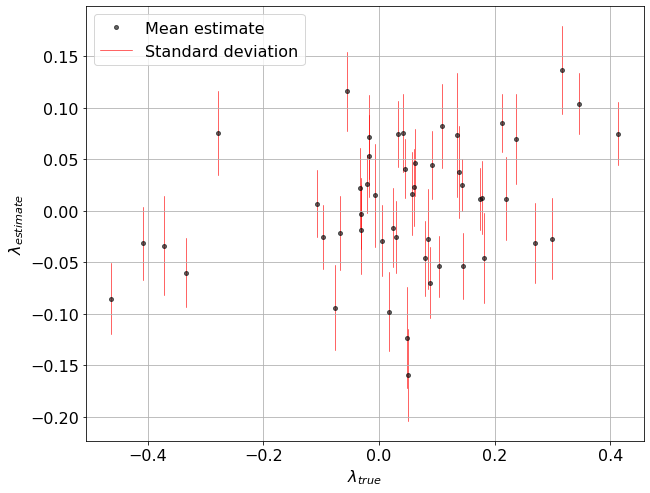

In [32]:
saveit = 1
plt.figure(1, figsize=(10,8))
p_names = ["Kr", "CaL", "K1", "Na", "NaL"]
p_idx = 4
for i in range(X_test.shape[0]):
    plt.plot(y_test[i, p_idx], y_mean[i, p_idx],'ko', alpha=0.6, markersize=4)
    plt.plot([y_test[i, p_idx], y_test[i, p_idx]],[y_lower[i, p_idx], y_upper[i, p_idx]], 'r-', lw=0.6, zorder=0)
# plt.xticks([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8])
# plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8])
plt.xlabel('$\lambda_{true}$')
plt.ylabel('$\lambda_{estimate}$')
plt.legend(["Mean estimate", "Standard deviation"])
plt.grid()
# plt.axis('equal')
if saveit:
    plt.savefig(f"plotpi_cnn1-2d-01_ne500_{p_names[p_idx]}.png",
                dpi=300, bbox_inches="tight")

# Validation curves

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)